In [1]:
import os
import adddeps
from simulator.models import Client_HDF5, Client, Simulation
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
from settings import HDF5_PATH
from sqlalchemy.orm import aliased

/home/ashmat/cluster/LJ-magnetic/simulator/base.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
client = Client()

In [3]:
with client.Session() as sess:
    data = dict()

    subquery = (sess.query(Simulation)
                                # .where(Simulation.group_name.in_(["Ensemble 9"]))
                                #  .where(Simulation.group_name.in_(["Ensemble 6","Ensemble 7","Ensemble 9"]))
                                 .order_by(Simulation.id.asc()).subquery().c)
    
    sess.query(subquery.start_time, subquery.finish_time).all()
    data["time"] = np.array([(f-s).total_seconds() for s,f in 
            sess.query(subquery.start_time, subquery.finish_time).all()
        ])
    data["N"] = np.array(sess.query(subquery.particles).all())[:,0]
    data["records"] = np.array(sess.query(subquery.iterations).all())[:,0]

    data["hash"] = np.array(sess.query(subquery.hash).all())[:,0]

    data["iterations"] = (data["records"] 
        / np.array(sess.query(subquery.dt).all())[:,0]
        *np.array(sess.query(subquery.record_interval).all())[:,0])



In [4]:
len(data["time"])

7510

In [5]:
set(data["iterations"])

{12.0,
 300010.0,
 300100.0,
 1000100.0,
 10001000.0,
 20000010.0,
 20001000.0,
 40000100.0}

In [6]:
set(np.array(sess.query(Simulation.dt).order_by(Simulation.id.asc()).all())[:,0])

{0.0001, 0.001}

In [7]:
np.array(sess.query(Simulation.record_interval).order_by(Simulation.id.asc()).all())[:,0]

array([0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1])

In [8]:
data["size"] = np.array(
    [os.stat(os.path.join(HDF5_PATH, _hash+".hdf5")).st_size for _hash in data["hash"]])

FileNotFoundError: [Errno 2] No such file or directory: '/data/biophys/ashmat/LJ-magnetic/hdf5s/9d056ead53fef7aa.hdf5'

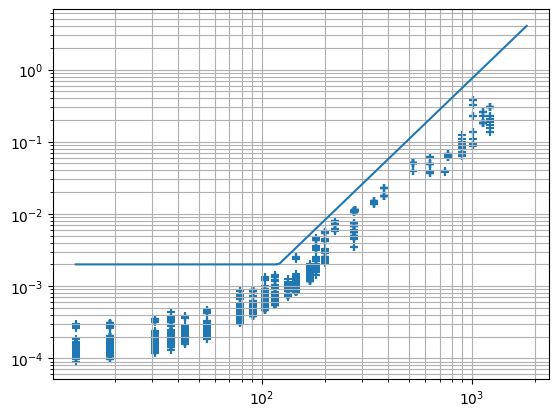

In [9]:
def f(n):
    return np.maximum(2e-3,  1.0e-7 * n**2.8 * 0.03)

plt.scatter(data["N"], data["time"]/data["iterations"],marker="+")
x=np.linspace(min(data["N"]), max(1.5*data["N"]),500)
plt.plot(x, f(x))
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.grid(which="both")
plt.minorticks_on()

In [10]:
data["N"]

array([ 169,   31,  379,  769,  895,  169,  769,  895,  277,  169,  769,
        277,  523,  277,  169,   31,  631,  277,  523,  631,  277,  895,
        631,  379,   31,  631,  523,  277,  769,   31,  379,  631,  379,
        895,  895,  769,  631,  379,  631, 1009,  379,  631,  379, 1009,
         31,  169,  895,  895, 1009,  379,  769,   31,  379,  277,  895,
        769,  523,  769,  169,  631,  277,   31,  379, 1009,  169,  523,
        523,  169,   31,  523,  277,   31, 1009,  769,  631,  523,  895,
        169,  277,  379,  769,  523,  631,  769, 1009,  631,  523,  769,
        523,   31,  379,  769,  895,  379,  277,  277,  523,   31,  379,
        169,  895,  169,  895,  631,  631,  895,  169,  631,   31,  277,
         31,  523,  769,  379,   31,  277,   31,  769,  169,  769,  169,
        379,  895, 1009,  895,  631,  379,  769,  277,  769,  379,  631,
        631,  523,  379,  895,  523,  169,  631,  631,  769,  523,  277,
        523,  277,  523,  895,  277,  769,  169,   

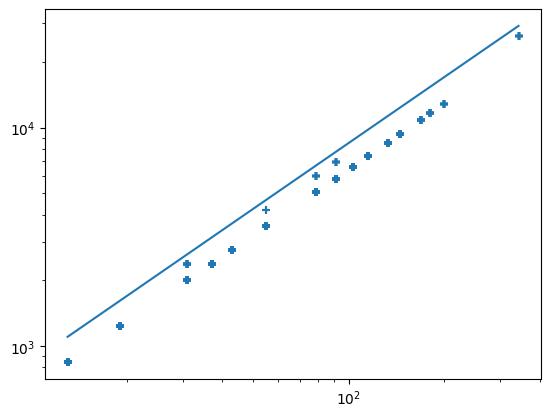

In [73]:
def f(n):
    return (85 * n)*1.0

plt.scatter(data["N"], data["size"]/data["records"],marker="+")
x=np.linspace(min(data["N"]), max(data["N"]),500)
plt.plot(x, f(x))
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

In [17]:
x.total_seconds()

50421.32185

In [15]:
len(data)

5882

In [17]:
data[1]-data[0]

TypeError: unsupported operand type(s) for -: 'Row' and 'Row'

In [13]:
data[1]-data[0]

TypeError: unsupported operand type(s) for -: 'str' and 'str'